# Vision Transformer Tutorial for the C - M symposium 2023

This is a rough draft of the tutorial that will be shown during the upcoming symposium. 

This notebook is supposed to complement a powerpoint presentation, and covers the following hands-on tasks: 
* Loading vision datasets
* Loading pre-trained model
* Training / fine-tuning model
* Understanding transformer
* Understanding attention

- Original vision transformer paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929

## Loading libraries

In [ ]:
import torchvision, torch
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import Subset

try:
    from timm import create_model
except:
    !pip install timm
    from timm import create_model
    
import timm
import torch.optim as optim
import torch.nn as nn

## Downloading dataset and loading dataset for training

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224,224))])
traindata_full = torchvision.datasets.CIFAR10('./cifar10_root/', download=True, train = True, transform = transform)
indices = list(range(4))
traindata = Subset(traindata_full, indices)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=4,shuffle=True, num_workers=1)

100%|██████████| 170498071/170498071 [00:02<00:00, 83909314.53it/s]


Extracting ./cifar10_root/cifar-10-python.tar.gz to ./cifar10_root/


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 228, 906])


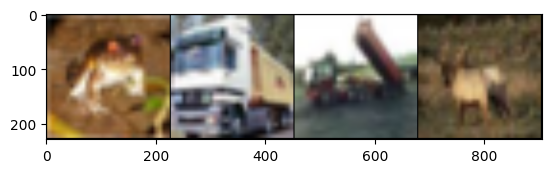

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.shape(img))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

## Loading models

In [ ]:
vit_models = timm.list_models('vit*', pretrained = True)
#vit_models

In [ ]:
model_name = 'vit_base_patch16_224.dino'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
model = create_model(model_name, pretrained = False).to(device)

device =  cpu


## Training model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Finished Training


## Model inference

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)
dataiter = iter(testloader)
images, labels = next(dataiter)

image = images[0]
img_tensor = image.unsqueeze(0).to(device)

In [ ]:
output = model(img_tensor)

In [ ]:
print("Inference Result:")
print(classes[int(torch.argmax(output))])
plt.imshow(image.permute(1,2,0).numpy())
plt.show()

## Understanding Vision Transformer: Images as sequence of patches

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

## Add position embeddings

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

## Make Transformer Input

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

# Transformer Encoder

In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

## Using attention mechanism for explaining model prediction

Notebook cells courtesy Hiroto Honda  [homepage](https://hirotomusiker.github.io/)  

<a href="http://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>  

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

In [ ]:
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 538, label name = dome



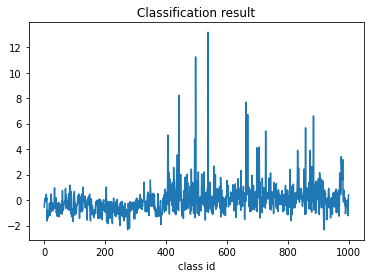

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))